In [1]:
# import tensorflow as tf

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model, Sequential
from librosa import display
from tensorflow.keras import layers

from classic_generator import classic_generator
from spectrogram_class import spectrogram


# Music transcription - MusicNet LSTM

This is a successive notebook from RNN models for OrchideaSOL dataset. In that notebook, we have demonstrate that the RNN model, in particularly LSTM, is able to capture the features of instrument and pitch in a raw audio file. 

The purpose of this notebook is to apply the same principle on the more complicated MusicNet dataset.

Although it is the same principle, this time we are going to need to convert the whole sequence of audio file into the transcription in to the same music file length. To be more clear:

> For all timesteps in the spectrogram, we are going to produce the classification of instruments and note. 

The end goal of this project is to convert the corresponding output into a MIDI file.

The model architecture will be to be fine tuned since we are facing the challenges below:

* We are making classifying prediction for every timestep,  
* Excluding the expected dimension of time and notes as output, we also need the same classification for every instruments, which is 11 of them.
* The audio files are not neccessarily made of single instrument, which means that our RNN model will need to find the relation of the sound signature for each instruments, in the sea of spectrogram's magnitude.
* The audio files has different length, range from 3 minutes to 20 minutes. Padding will be required, however, zeros padding will cause problem of exploding/vanishing gradient in RNN model.

In [3]:
# Testing if GPU is enabled, if it's not, I am not running this notebook!
tf.config.list_physical_devices('GPU')


2022-08-05 10:45:03.766135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:03.790829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:03.791113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-05 10:45:03.805341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 10:45:03.806736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:03.807277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:03.807679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

True

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16610190889474048208
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3534618624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7022899192160388826
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-08-05 10:45:04.507596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.508049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.508360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.508698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.508966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Throughout this notebook, we will be using integer code number for instrument and notes classification. The instrument and note lists below are generated by concatenating the training labels, which are seperated csv files.

In [6]:
instrument_list = [1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]


In [7]:
note_list = [21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
             63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


# RNN-LSTM

To begin our construction of RNN model, we introduce the architect idea for our model.

Since our model has to output the MIDI file equivalence for each instruments, we will be forking our output into 11 Dense layers, with each layer reprenting one instruments.

Each output will have a dimension of :
$$
(\text{\# of timesteps} \times \text{\# of notes})
$$

In [8]:
def instrument_layer_simple(input, out_name):
    # out = layers.LSTM(len(note_list), return_sequences=True, activation = 'sigmoid'
    #                     , name = f"{out_name}")(input)

    # inner = layers.TimeDistributed(layers.Flatten())(input)
    # inner = layers.TimeDistributed(layers.Dense(200, activation = 'relu', 
    #                                 kernel_regularizer=tf.keras.regularizers.L1(l1=0.01)))(input)
    # inner = layers.BatchNormalization()(inner)
    # inner = layers.Dropout(0.2)(inner)

    out = layers.TimeDistributed(layers.Dense(len(note_list), activation='sigmoid'),
                                 name=out_name)(input)
    return out


In [9]:
instrument_list


[1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

In [10]:
from tensorflow.keras.backend import int_shape

inp = layers.Input((None, 64, 1), batch_size=1)
normalizer = layers.BatchNormalization()(inp)

lstm = layers.ConvLSTM1D(20, 20, return_sequences=True,
                         kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(normalizer)

normalizer_2 = layers.BatchNormalization()(lstm)
pool_1 = layers.TimeDistributed(layers.MaxPool1D(2))(normalizer_2)
conv = layers.TimeDistributed(layers.Conv1D(30, 300, padding = 'same'))(pool_1)
flatten = layers.TimeDistributed(layers.Flatten())(pool_1)

Dense_1 = layers.TimeDistributed(layers.Dense(200, activation = 'relu'))(flatten)
normalizer_3 = layers.BatchNormalization()(Dense_1)
drop_1 = layers.Dropout(0.2)(normalizer_3)

simple_lstm_model = Model(inp, [instrument_layer_simple(drop_1,
                                f"instrument_{ins}") for ins in instrument_list])
# [instrument_1, instrument_7, instrument_41, instrument_42,
# instrument_43, instrument_44, instrument_61,
# instrument_69, instrument_71, instrument_72,
# instrument_74])


2022-08-05 10:45:04.554139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.554515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.554760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.555118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:45:04.555463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

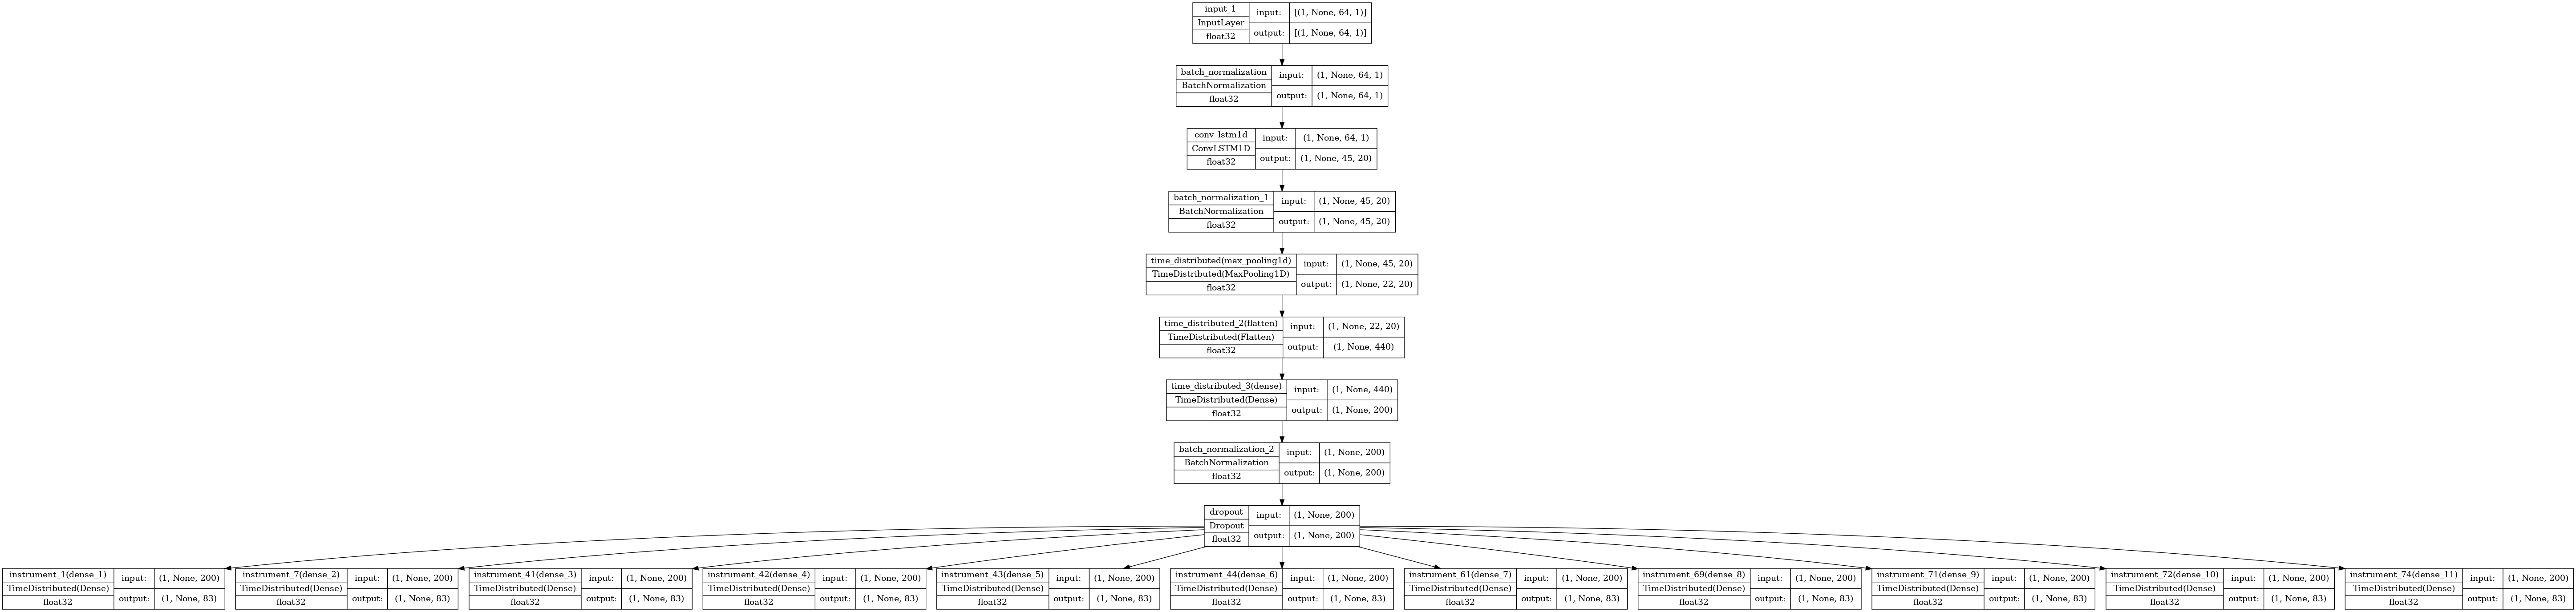

In [11]:

tf.keras.utils.plot_model(simple_lstm_model, show_shapes=True, show_dtype=True)


In [12]:
classic_train_generator =  classic_generator(mode='train', batch_size=1)
                        # (tf.dtypes.float32, tf.dtypes.bool))

classic_eval_generator = classic_generator(mode='test', batch_size=1)


In [13]:

simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                          loss={f"instrument_{ins}": tf.keras.losses.BinaryCrossentropy()
                                for ins in instrument_list},
                          metrics=['accuracy'])


In [14]:
# Getting the path to the latest trained model
newest_ckpt = !ls -dt $PWD/../models/classic_convlstm/* | head -1
newest_ckpt = newest_ckpt[0]
newest_ckpt


'/home/shiya/Documents/music_transcription/notebooks/../models/classic_convlstm/20220805_103454_01_classic_convlstm'

In [15]:
# simple_lstm_model = tf.keras.models.load_model(newest_ckpt)
# 

In [16]:
simple_lstm_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, None, 64, 1)]   0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (1, None, 64, 1)    4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (1, None, 45, 20)    33680       ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (1, None, 45, 20)   80          ['conv_lstm1d[0][0]']        

In [ ]:
from datetime import datetime
from logging import warning
import warnings

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/classic_convlstm/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_classic_convlstm",
    monitor='val_accuracy',
    save_freq=10)
    
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)

with warnings.catch_warnings():
    warnings.filterwarnings(
        action='ignore',
        module='numba')

    simple_lstm_history = simple_lstm_model.fit(classic_train_generator, 
                                                epochs=10,
                                                validation_data=classic_eval_generator,
                                                validation_freq=1,
                                                use_multiprocessing= True,
                                                workers= 3,
                                                verbose=1,
                                                callbacks=[ckpt_callback])


Epoch 1/10


2022-08-05 10:45:15.037101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-05 10:45:15.843350: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 10:45:15.844107: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 10:45:15.844143: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-05 10:45:15.844979: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 10:45:15.845069: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 89/320 [=======>......................] - ETA: 45:24 - loss: 2.4489 - instrument_1_loss: 0.2668 - instrument_7_loss: 0.2060 - instrument_41_loss: 0.2196 - instrument_42_loss: 0.2139 - instrument_43_loss: 0.2144 - instrument_44_loss: 0.2025 - instrument_61_loss: 0.2047 - instrument_69_loss: 0.2068 - instrument_71_loss: 0.2078 - instrument_72_loss: 0.2064 - instrument_74_loss: 0.2031 - instrument_1_accuracy: 0.0135 - instrument_7_accuracy: 0.0016 - instrument_41_accuracy: 0.0094 - instrument_42_accuracy: 0.0064 - instrument_43_accuracy: 0.0049 - instrument_44_accuracy: 0.0059 - instrument_61_accuracy: 0.0020 - instrument_69_accuracy: 0.0011 - instrument_71_accuracy: 0.0026 - instrument_72_accuracy: 0.0055 - instrument_74_accuracy: 0.0035INFO:tensorflow:Assets written to: ../models/classic_convlstm/20220805_104505_01_classic_convlstm/assets


179/320 [===============>..............] - ETA: 30:14 - loss: 1.3176 - instrument_1_loss: 0.1781 - instrument_7_loss: 0.1033 - instrument_41_loss: 0.1246 - instrument_42_loss: 0.1151 - instrument_43_loss: 0.1165 - instrument_44_loss: 0.1018 - instrument_61_loss: 0.1048 - instrument_69_loss: 0.1046 - instrument_71_loss: 0.1065 - instrument_72_loss: 0.1068 - instrument_74_loss: 0.1030 - instrument_1_accuracy: 0.0135 - instrument_7_accuracy: 7.7174e-04 - instrument_41_accuracy: 0.0142 - instrument_42_accuracy: 0.0088 - instrument_43_accuracy: 0.0076 - instrument_44_accuracy: 0.0036 - instrument_61_accuracy: 0.0044 - instrument_69_accuracy: 9.9493e-04 - instrument_71_accuracy: 0.0038 - instrument_72_accuracy: 0.0049 - instrument_74_accuracy: 0.0025INFO:tensorflow:Assets written to: ../models/classic_convlstm/20220805_104505_01_classic_convlstm/assets


232/320 [====================>.........] - ETA: 18:56 - loss: 1.0596 - instrument_1_loss: 0.1612 - instrument_7_loss: 0.0799 - instrument_41_loss: 0.1027 - instrument_42_loss: 0.0924 - instrument_43_loss: 0.0941 - instrument_44_loss: 0.0789 - instrument_61_loss: 0.0812 - instrument_69_loss: 0.0812 - instrument_71_loss: 0.0827 - instrument_72_loss: 0.0832 - instrument_74_loss: 0.0799 - instrument_1_accuracy: 0.0131 - instrument_7_accuracy: 6.0935e-04 - instrument_41_accuracy: 0.0146 - instrument_42_accuracy: 0.0089 - instrument_43_accuracy: 0.0079 - instrument_44_accuracy: 0.0035 - instrument_61_accuracy: 0.0036 - instrument_69_accuracy: 9.3899e-04 - instrument_71_accuracy: 0.0032 - instrument_72_accuracy: 0.0040 - instrument_74_accuracy: 0.0021

In [ ]:
simple_lstm_model.save('../models/classic_full_convlstm/')


In [ ]:
test_generator = classic_generator(mode='train', batch_size=2)


In [ ]:
test_set = test_generator.__getitem__(2)


In [ ]:
test_set[0].shape


In [ ]:
predict_test = simple_lstm_model.predict(test_set[0])


In [ ]:
predict_test[5][0][-1]


In [ ]:
np.where(predict_test[5][0] <= 0, 0, 1)[-1]


In [ ]:
for x in len(predict_test):
    fig, axes = plt.subplots(len(predict_test), )
    sns.heatmap(np.where(x[1] <= 0, 0, 1))
    plt.show()


In [ ]:
sns.heatmap(np.where(predict_test[0][1] <= 0, 0, 1))


In [ ]:
predict_test[9][0]

In [ ]:
sns.heatmap(predict_test[6][0])

In [ ]:
instrument_list

In [ ]:
sns.heatmap(test_set[1]['instrument_41'][0])
